<a href="https://colab.research.google.com/github/SankalpC10/Colab_Notebooks/blob/main/CLV_LTV_LTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/preprocess_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/preprocess_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [47]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import os
import numpy as np
import pandas as pd
import tqdm
import multiprocessing
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from typing import Sequence

!pip install -q git+https://github.com/seyedrezamirkhani/lifetime_value
import lifetime_value as ltv

  Preparing metadata (setup.py) ... done


In [48]:
from sklearn import metrics
import pickle

In [49]:
pd.options.mode.chained_assignment = None  # default='warn'

In [50]:
def zero_inflated_lognormal_pred(logits: tf.Tensor) -> tf.Tensor:
  """Calculates predicted mean of zero inflated lognormal logits.

  Arguments:
    logits: [batch_size, 3] tensor of logits.

  Returns:
    preds: [batch_size, 1] tensor of predicted mean.
  """
  logits = tf.convert_to_tensor(logits, dtype=tf.float32)
  positive_probs = tf.keras.backend.sigmoid(logits[..., :1])
  loc = logits[..., 1:2]
  scale = tf.keras.backend.softplus(logits[..., 2:])
  preds = (
      positive_probs *
      tf.keras.backend.exp(loc + 0.5 * tf.keras.backend.square(scale)))
  return preds

@tf.keras.utils.register_keras_serializable()
def zero_inflated_lognormal_loss(labels: tf.Tensor,
                                 logits: tf.Tensor) -> tf.Tensor:
  """Computes the zero inflated lognormal loss.

  Usage with tf.keras API:

  ```python
  model = tf.keras.Model(inputs, outputs)
  model.compile('sgd', loss=zero_inflated_lognormal)
  ```

  Arguments:
    labels: True targets, tensor of shape [batch_size, 1].
    logits: Logits of output layer, tensor of shape [batch_size, 3].

  Returns:
    Zero inflated lognormal loss value.
  """
  labels = tf.convert_to_tensor(labels, dtype=tf.float32)
  positive = tf.cast(labels > 0, tf.float32)

  logits = tf.convert_to_tensor(logits, dtype=tf.float32)
  logits.shape.assert_is_compatible_with(
      tf.TensorShape(labels.shape[:-1].as_list() + [3]))

  positive_logits = logits[..., :1]
  classification_loss = tf.keras.losses.binary_crossentropy(
      y_true=positive, y_pred=positive_logits, from_logits=True)

  loc = logits[..., 1:2]
  scale = tf.math.maximum(
      tf.keras.backend.softplus(logits[..., 2:]),
      tf.math.sqrt(tf.keras.backend.epsilon()))
  safe_labels = positive * labels + (
      1 - positive) * tf.keras.backend.ones_like(labels)
  regression_loss = -tf.keras.backend.mean(
      positive * tfd.LogNormal(loc=loc, scale=scale).log_prob(safe_labels),
      axis=-1)

  return classification_loss + regression_loss

## Global variables

In [51]:
COMPANY = '104900040'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
# LOSS = 'bce'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
# MODEL = 'linear'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}
DATA_FOLDER = './tmp/acquire-valued-shoppers-challenge' # @param { isTemplate: true, type: 'string'}
OUTPUT_CSV_FOLDER = f'{DATA_FOLDER}/result'  # @param { isTemplate: true, type: 'string'}

## Data

In [52]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [53]:
# Set it DATA_FOLDER as an environment variable
%env DATA_FOLDER=$DATA_FOLDER

env: DATA_FOLDER=./tmp/acquire-valued-shoppers-challenge


### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api
```
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"{your kaggle username}\",\"key\":\"{your kaggle api key}\"\} > ~/.kaggle/kaggle.json
pip install kaggle
```

In [54]:
%%shell
mkdir ~/.kaggle
echo \{\"username\":\"sankalpchavhan\",\"key\":\"c2c7e3b5079f84cb89cb3557fbcc2aa2\"\} > ~/.kaggle/kaggle.json
pip install kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [55]:
%%bash
if [ -e $DATA_FOLDER/transactions.csv ]
then
  echo "File already exists, no need to download."
else
  rm -rf $DATA_FOLDER
  mkdir -p $DATA_FOLDER
  cd $DATA_FOLDER
  kaggle competitions download -c acquire-valued-shoppers-challenge
  echo "Unzip file. This may take 10 min."
  unzip acquire-valued-shoppers-challenge.zip transactions.csv.gz
  gunzip transactions.csv.gz
fi

File already exists, no need to download.


### Load csv

In [56]:
def load_transaction_data(company):
  all_data_filename = f'{DATA_FOLDER}/transactions.csv'
  one_company_data_filename = f'{DATA_FOLDER}/transactions_company_{company}.csv'
  desired_columns = ['id', 'date', 'purchasequantity', 'purchaseamount']
  if os.path.isfile(one_company_data_filename):
    df = pd.read_csv(one_company_data_filename)
  else:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=={}".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return df

### Preprocess data

In [57]:
def preprocess(df):
    df = df.query('purchaseamount > 0')

    # Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Calculate the start date for each customer (minimum date per ID)
    df['start_date'] = df.groupby('id')['date'].transform('min')

    # Compute calibration values (purchaseamount on start_date)
    calibration_value = (
        df.query('date == start_date')
        .groupby('id')['purchaseamount']
        .sum()
        .reset_index()
    )
    calibration_value.columns = ['id', 'calibration_value']

    # Compute holdout values (purchaseamount within a one-year window after start_date)
    one_year_holdout_window_mask = (
        (df['date'] > df['start_date']) &
        (df['date'] <= df['start_date'] + np.timedelta64(365, 'D'))
    )
    holdout_value = (
        df[one_year_holdout_window_mask]
        .groupby('id')['purchaseamount']
        .sum()
        .reset_index()
    )
    holdout_value.columns = ['id', 'holdout_value']

    # Merge calibration and holdout data
    customer_level_data = calibration_value.merge(holdout_value, how='left', on='id')

    # Fill missing holdout values with 0
    customer_level_data['holdout_value'] = customer_level_data['holdout_value'].fillna(0.)

    # Compute log of calibration value for modeling purposes
    customer_level_data['log_calibration_value'] = (
        np.log(customer_level_data['calibration_value']).astype('float32')
    )

    # Add a label column for modeling (optional, based on use case)
    customer_level_data['label'] = customer_level_data['holdout_value'].astype('float32')

    return customer_level_data

In [58]:
def load_customer_level_csv(company):
  customer_level_data_file = f'{DATA_FOLDER}/customer_level_data_company_{company}.csv'
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  # for cat_col in CATEGORICAL_FEATURES:
  #   customer_level_data[cat_col] = (
  #       customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

This step may take a while to finish -- 10min-1hr depending on number of core in
the computer.

In [59]:
# Processes data. 350 iteration in total. May take 10min.
customer_level_data = load_customer_level_csv(COMPANY)

In [60]:
customer_level_data

,id,calibration_value,holdout_value,log_calibration_value,label
0,86246,11.58,358.260010,2.449280,358.260010
1,86252,0.99,336.649994,-0.010050,336.649994
2,12262064,1.72,32.310001,0.542324,32.310001
3,12277270,4.49,186.750000,1.501853,186.750000
4,12332190,1.49,53.610001,0.398776,53.610001
...,...,...,...,...,...
249280,4824696849,1.00,0.000000,0.000000,0.000000
249281,4829517835,6.98,0.000000,1.943049,0.000000
249282,4837642552,4.99,14.970000,1.607436,14.970000
249283,4847628950,16.65,71.110001,2.812410,71.110001


<Axes: >

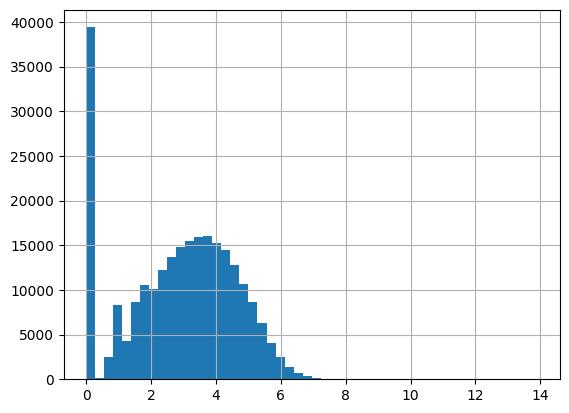

In [61]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

In [62]:
customer_level_data.head().T

,0,1,2,3,4
id,86246.00000,86252.000000,1.226206e+07,1.227727e+07,1.233219e+07
calibration_value,11.58000,0.990000,1.720000e+00,4.490000e+00,1.490000e+00
holdout_value,358.26001,336.649994,3.231000e+01,1.867500e+02,5.361000e+01
log_calibration_value,2.44928,-0.010050,5.423243e-01,1.501853e+00,3.987761e-01
label,358.26001,336.649994,3.231000e+01,1.867500e+02,5.361000e+01


In [63]:
def dnn_split(df):
    # encoder_dir = 'encoders'
    # os.makedirs(encoder_dir, exist_ok=True)

    # Dictionary to store encoders
    # encoders = {}
    # for key in CATEGORICAL_FEATURES:
    #   encoder = preprocessing.LabelEncoder()
    #   df[key] = encoder.fit_transform(df[key])
    #   with open(os.path.join(encoder_dir, f"{key}_encoder.pkl"), 'wb') as f:
    #         pickle.dump(encoder, f)

    #   encoders[key] = encoder

    df_train, df_eval = model_selection.train_test_split(
        df, test_size=0.2, random_state=123)

    def feature_dict(df):
      features = {}
      features['numeric'] = df[NUMERIC_FEATURES].values
      return features

    x_train, y_train = feature_dict(df_train), df_train['label'].values
    x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

    return x_train, x_eval, y_train, y_eval

In [64]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size)
      ),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  # embedding_inputs = [
  #     tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
  #     for key in CATEGORICAL_FEATURES
  # ]

  # embedding_outputs = [
  #     # embedding_layer(vocab_size=df[key].nunique())(input)
  #     embedding_layer(vocab_size=134)(input)
  #     for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  # ]

  deep_input = tf.keras.layers.concatenate([numeric_input])
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input], outputs=deep_model(deep_input))

In [65]:
if LOSS == 'bce':
  loss = keras.losses.BinaryCrossentropy(from_logits=True)
  output_units = 1

if LOSS == 'ziln':
  loss = zero_inflated_lognormal_loss
  output_units = 3

In [66]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval = linear_split(customer_level_data)
  model = linear_model(output_units, x_train.shape[1])

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [67]:
if LOSS == 'bce':
  y_train = (y_train > 0).astype('float32')
  y_eval = (y_eval > 0).astype('float32')

In [68]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [69]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [70]:
history = model.fit(
    x=x_train,
    y=y_train[:, np.newaxis],
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval[:, np.newaxis])).history

Epoch 1/400
195/195 - 3s - 14ms/step - loss: 9.3071 - val_loss: 7.1071 - learning_rate: 2.0000e-04
Epoch 2/400
195/195 - 1s - 5ms/step - loss: 6.2506 - val_loss: 5.6456 - learning_rate: 2.0000e-04
Epoch 3/400
195/195 - 1s - 4ms/step - loss: 5.3281 - val_loss: 5.1099 - learning_rate: 2.0000e-04
Epoch 4/400
195/195 - 2s - 8ms/step - loss: 4.9046 - val_loss: 4.7395 - learning_rate: 2.0000e-04
Epoch 5/400
195/195 - 1s - 4ms/step - loss: 4.6779 - val_loss: 4.6711 - learning_rate: 2.0000e-04
Epoch 6/400
195/195 - 1s - 4ms/step - loss: 4.6509 - val_loss: 4.6602 - learning_rate: 2.0000e-04
Epoch 7/400
195/195 - 1s - 4ms/step - loss: 4.6462 - val_loss: 4.6586 - learning_rate: 2.0000e-04
Epoch 8/400
195/195 - 1s - 6ms/step - loss: 4.6453 - val_loss: 4.6579 - learning_rate: 2.0000e-04
Epoch 9/400
195/195 - 2s - 8ms/step - loss: 4.6448 - val_loss: 4.6578 - learning_rate: 2.0000e-04
Epoch 10/400
195/195 - 2s - 9ms/step - loss: 4.6447 - val_loss: 4.6577 - learning_rate: 2.0000e-04
Epoch 11/400
195/1

<Axes: >

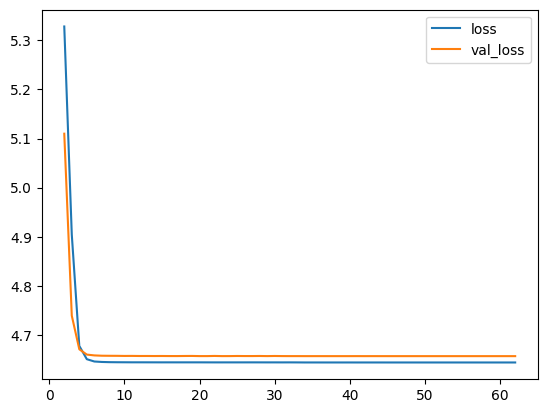

In [80]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

In [81]:
logits = model.predict(x=x_eval, batch_size=1024)
y_pred = K.sigmoid(logits[..., :1]).numpy().flatten()

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [82]:
x_train

{'numeric': array([[1.7917595 ],
        [1.2029723 ],
        [1.178655  ],
        ...,
        [2.014903  ],
        [0.51282364],
        [1.0986123 ]], dtype=float32)}

In [83]:
x_eval

{'numeric': array([[-0.01005034],
        [ 2.0769384 ],
        [ 1.5040774 ],
        ...,
        [ 0.46373403],
        [ 1.9139771 ],
        [ 1.7917595 ]], dtype=float32)}

In [84]:
y_true = (y_eval > 0).astype('float32')

In [85]:
def classification_report(y_true: Sequence[int],
                          y_pred: Sequence[float]) -> pd.DataFrame:
  """Report individual level classification metrics.

  Arguments:
    y_true: true binary labels.
    y_pred: predicted binary labels.

  Returns:
    out: dataframe with classification metrics as columns.
  """
  out = pd.DataFrame(index=[0])

  out['AUC'] = metrics.roc_auc_score(y_true, y_pred)
  out['PR_AUC'] = metrics.average_precision_score(y_true, y_pred)
  out['precision'] = metrics.precision_score(y_true, 1 * (y_pred > .5))
  out['recall'] = metrics.recall_score(y_true, 1 * (y_pred > .5))
  out['f1'] = metrics.f1_score(y_true, 1 * (y_pred > .5))
  return out

In [86]:
classification = classification_report(y_true, y_pred)
classification

,AUC,PR_AUC,precision,recall,f1
0,0.580583,0.880391,0.844395,1.0,0.915634


In [87]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_true.mean(),
        'pred_mean': y_pred.mean(),
        'AUC': classification.loc[0, 'AUC'],
        'PR_AUC': classification.loc[0, 'PR_AUC'],
        'precision': classification.loc[0, 'precision'],
        'recall': classification.loc[0, 'recall'],
        'f1': classification.loc[0, 'f1']
    },
    index=[0])

In [88]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'AUC',
    'PR_AUC',
    'precision',
    'recall',
    'f1',
]]

,company,model,loss,label_mean,pred_mean,AUC,PR_AUC,precision,recall,f1
0,104900040,dnn,ziln,0.844395,0.841842,0.580583,0.880391,0.844395,1.0,0.915634


## Regression

In [93]:
def dnn_split(df):
  # for key in CATEGORICAL_FEATURES:
  #   encoder = preprocessing.LabelEncoder()
  #   df[key] = encoder.fit_transform(df[key])

  y0 = df['calibration_value'].values
  df_train, df_eval, y0_train, y0_eval = model_selection.train_test_split(
      df, y0, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {}
    features['numeric'] = df[NUMERIC_FEATURES].values
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

  return x_train, x_eval, y_train, y_eval, y0_eval

In [94]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size)
      ),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  # embedding_inputs = [
  #     tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
  #     for key in CATEGORICAL_FEATURES
  # ]

  # embedding_outputs = [
  #     embedding_layer(vocab_size=df[key].nunique())(input)
  #     for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  # ]

  deep_input = tf.keras.layers.concatenate([numeric_input])
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input], outputs=deep_model(deep_input))

In [95]:
if LOSS == 'mse':
  loss = keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [96]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval, y0_eval = linear_split(customer_level_data)
  model = linear_model(output_units, x_train.shape[1])

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval, y0_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [97]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [98]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [99]:
history = model.fit(
    x=x_train,
    y=y_train[:, np.newaxis],
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval[:, np.newaxis])).history

Epoch 1/400
195/195 - 4s - 21ms/step - loss: 11.6828 - val_loss: 7.5063 - learning_rate: 2.0000e-04
Epoch 2/400
195/195 - 2s - 9ms/step - loss: 6.0583 - val_loss: 5.3188 - learning_rate: 2.0000e-04
Epoch 3/400
195/195 - 1s - 5ms/step - loss: 5.0204 - val_loss: 4.8372 - learning_rate: 2.0000e-04
Epoch 4/400
195/195 - 1s - 4ms/step - loss: 4.7193 - val_loss: 4.6807 - learning_rate: 2.0000e-04
Epoch 5/400
195/195 - 1s - 7ms/step - loss: 4.6557 - val_loss: 4.6631 - learning_rate: 2.0000e-04
Epoch 6/400
195/195 - 1s - 3ms/step - loss: 4.6481 - val_loss: 4.6599 - learning_rate: 2.0000e-04
Epoch 7/400
195/195 - 1s - 3ms/step - loss: 4.6462 - val_loss: 4.6586 - learning_rate: 2.0000e-04
Epoch 8/400
195/195 - 1s - 6ms/step - loss: 4.6454 - val_loss: 4.6583 - learning_rate: 2.0000e-04
Epoch 9/400
195/195 - 1s - 3ms/step - loss: 4.6451 - val_loss: 4.6580 - learning_rate: 2.0000e-04
Epoch 10/400
195/195 - 1s - 4ms/step - loss: 4.6449 - val_loss: 4.6578 - learning_rate: 2.0000e-04
Epoch 11/400
195/

<Axes: >

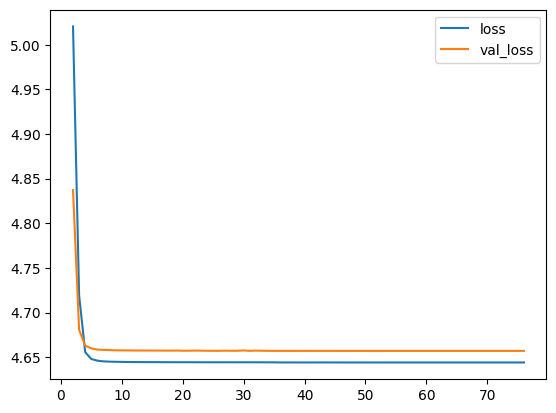

In [100]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

In [101]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [102]:
df_pred = pd.DataFrame({
    'y_true': y_eval,
    'y_pred': y_pred,
})
df_pred.head(10)

,y_true,y_pred
0,19.209999,28.567703
1,0.000000,83.520393
2,165.000000,54.910908
3,39.849998,57.605236
4,49.840000,35.363922
5,43.080002,68.203072
6,185.179993,86.165382
7,25.840000,50.156017
8,0.000000,32.469906
9,31.780001,46.933472


## Gini Coefficient

In [103]:

gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, y0_eval),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [104]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

Text(0.5, 1.0, 'Gain Chart')

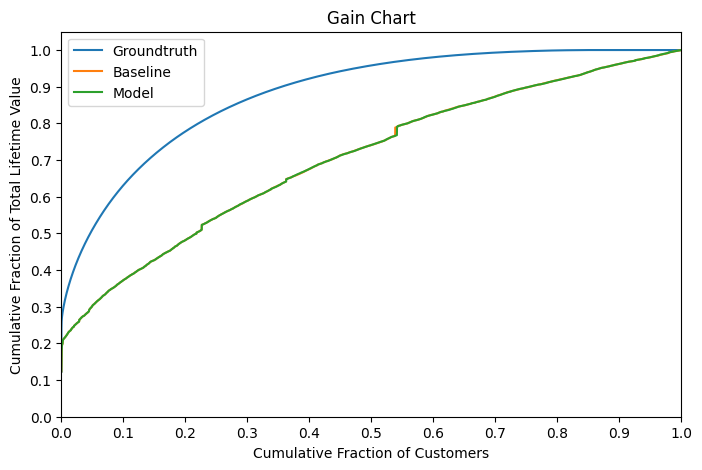

In [105]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='upper left')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart')

In [106]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

/usr/local/lib/python3.10/dist-packages/lifetime_value/metrics.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized = raw / raw[0]


,raw,normalized
lorenz,0.764284,1.000000
baseline,0.411868,0.538895
model,0.411773,0.538770


In [107]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

/usr/local/lib/python3.10/dist-packages/lifetime_value/metrics.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('decile').apply(_aggregate_fn)


,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,27.650345,29.205067,2.895361,1.105732,0.056228
1,32.059872,33.719658,1.982413,1.100672,0.051771
2,34.199162,35.417496,2.131474,1.112359,0.035625
3,35.247742,39.609447,1.821415,1.102530,0.123744
4,59.481804,47.410107,18.793360,1.036452,0.202948
5,50.341099,54.989391,1.702175,1.017616,0.092336
6,65.577087,63.333935,5.870142,0.975430,0.034206
7,77.791641,74.494690,8.589913,1.005056,0.042382
8,80.982285,99.578819,1.464704,1.026104,0.229637


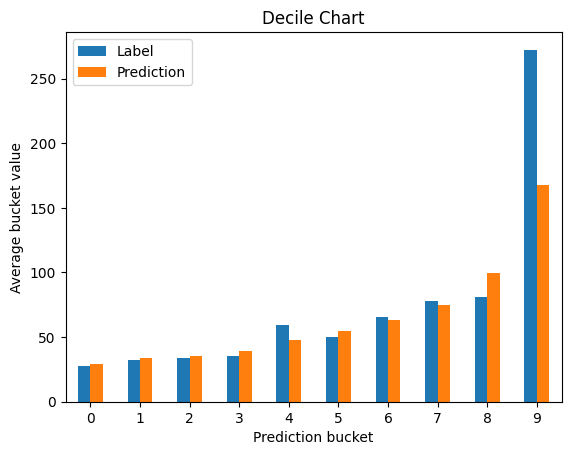

In [108]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left')

In [109]:
def spearmanr(x1: Sequence[float], x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

0.2940834845763596

In [110]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_eval.mean(),
        'pred_mean': y_pred.mean(),
        'label_positive': np.mean(y_eval > 0),
        'decile_mape': df_decile['decile_mape'].mean(),
        'baseline_gini': gini['normalized'][1],
        'gini': gini['normalized'][2],
        'spearman_corr': spearman_corr,
    },
    index=[0])

<ipython-input-110-c1a784d2a184>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'baseline_gini': gini['normalized'][1],
<ipython-input-110-c1a784d2a184>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'gini': gini['normalized'][2],


In [111]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'label_positive',
    'decile_mape',
    'baseline_gini',
    'gini',
    'spearman_corr',
]]

,company,model,loss,label_mean,pred_mean,label_positive,decile_mape,baseline_gini,gini,spearman_corr
0,104900040,dnn,ziln,73.107872,64.010986,0.844395,0.125206,0.538895,0.53877,0.294083
